In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## debug kernel centering

In [2]:
def center(kernel):
    """Center the kernel matrix, such that the mean (in feature space) is zero."""
    one_mat = np.ones(kernel.shape) # kernel shape, i.e. (n_train+n_test, n_train+n_test)
    one_vec = np.ones((kernel.shape[0],)) # (n_train+n_test, 1)

    row_sum = np.mean(kernel,axis=0).T # (n_train+n_test, 1)
    print(row_sum)
    print(row_sum.dot(one_vec.T))
    print(one_vec.dot(row_sum.T))
    print(np.mean(row_sum)*one_mat)
    
    kernel_centered = kernel - row_sum.dot(one_vec.T) - one_vec.dot(row_sum.T) +\
            np.mean(row_sum)*one_mat
    return kernel_centered

In [3]:
from numpy import array, matrix
from numpy import zeros, ones, eye, diag
from numpy import average, exp, kron, sum
from numpy import sqrt, divide, mean, multiply


def center(K):
    """Center the kernel matrix, such that the mean (in feature space) is zero."""
    one_mat = ones(K.shape) # 10,10
    one_vec = ones((K.shape[0],1)) # 10,1

    row_sum = mean(K,axis=0).T # 10,
    row_sum = row_sum.reshape(row_sum.shape[0],1) # 10,1
    R = K - row_sum.dot(one_vec.T) - one_vec.dot(row_sum.T) +\
        mean(row_sum)*one_mat
    return R


In [4]:
phi = np.random.rand(10,5) # 10,5
k = phi.dot(phi.T) # 10,10
k

array([[2.41612945, 0.97291083, 1.60237559, 2.35044419, 0.59912471,
        1.18450833, 1.45325116, 1.00322145, 1.34635624, 1.96171773],
       [0.97291083, 0.95385046, 0.4064414 , 1.31134473, 0.54266624,
        0.40200504, 0.43979528, 0.49872361, 0.56640337, 0.80877201],
       [1.60237559, 0.4064414 , 1.39621791, 1.2870571 , 0.32411612,
        0.79045775, 1.17288112, 0.65121555, 0.75049896, 1.21136884],
       [2.35044419, 1.31134473, 1.2870571 , 2.71016018, 0.65936103,
        0.9405003 , 1.2485813 , 0.85035685, 1.33836686, 2.0530446 ],
       [0.59912471, 0.54266624, 0.32411612, 0.65936103, 0.39428787,
        0.38643527, 0.31441418, 0.4179261 , 0.37773661, 0.39780957],
       [1.18450833, 0.40200504, 0.79045775, 0.9405003 , 0.38643527,
        0.8671803 , 0.70921583, 0.68831557, 0.80034595, 0.81039363],
       [1.45325116, 0.43979528, 1.17288112, 1.2485813 , 0.31441418,
        0.70921583, 1.00533924, 0.59186003, 0.71657166, 1.12662714],
       [1.00322145, 0.49872361, 0.6512155

In [5]:
phi_centered = phi - np.mean(phi, axis = 0)
k_centered_by_phi = phi_centered.dot(phi_centered.T)
np.linalg.eigh(k_centered_by_phi)

(array([-9.01138324e-17, -3.48959146e-17,  1.12519868e-17,  8.61271317e-17,
         3.55452850e-16,  9.76579728e-02,  1.64239670e-01,  4.37855324e-01,
         1.18755975e+00,  1.83557308e+00]),
 array([[-0.03889188,  0.12267927, -0.04744143, -0.10448244,  0.65479275,
          0.48965433, -0.30524315,  0.15488321,  0.12996881, -0.40951307],
        [-0.10175564, -0.53380236, -0.0364036 ,  0.26755084,  0.37320961,
          0.14079539,  0.04293235, -0.32576408, -0.5637072 ,  0.2166845 ],
        [ 0.3962894 , -0.38992656,  0.38428465, -0.1267576 ,  0.02835184,
          0.17056435,  0.18879708, -0.43590376,  0.51786634, -0.05858172],
        [-0.20322804, -0.03193153,  0.58182249, -0.14765485, -0.3479594 ,
          0.17738952,  0.01961443,  0.01359389, -0.42918043, -0.50995219],
        [ 0.12217585,  0.5908406 ,  0.43233134, -0.22126942,  0.30375717,
          0.03491208,  0.14362463, -0.18765347, -0.21064305,  0.45432398],
        [-0.08280509, -0.0778176 ,  0.47797288,  0.61894504

In [6]:
k_centered_by_phi

array([[ 0.37710849, -0.26739746,  0.09309556,  0.32550548, -0.39228006,
        -0.12344447,  0.02538047, -0.21524665, -0.04941336,  0.22669199],
       [-0.26739746,  0.51225484, -0.30412596,  0.08511869,  0.34997415,
        -0.10723508, -0.18936274,  0.07896818, -0.03065356, -0.12754106],
       [ 0.09309556, -0.30412596,  0.41667881, -0.20814068, -0.13754771,
         0.01224589,  0.27475136, -0.03751162, -0.11552971,  0.00608404],
       [ 0.32550548,  0.08511869, -0.20814068,  0.69930372, -0.31796148,
        -0.35337024, -0.16520713, -0.354029  , -0.04332049,  0.33210111],
       [-0.39228006,  0.34997415, -0.13754771, -0.31796148,  0.4504993 ,
         0.12609868, -0.06584031,  0.24707419,  0.02958321, -0.28959997],
       [-0.12344447, -0.10723508,  0.01224589, -0.35337024,  0.12609868,
         0.29029568,  0.01241332,  0.20091564,  0.13564452, -0.19356394],
       [ 0.02538047, -0.18936274,  0.27475136, -0.16520713, -0.06584031,
         0.01241332,  0.18861883, -0.01545779

In [7]:
center(k)

array([[ 0.37710849, -0.26739746,  0.09309556,  0.32550548, -0.39228006,
        -0.12344447,  0.02538047, -0.21524665, -0.04941336,  0.22669199],
       [-0.26739746,  0.51225484, -0.30412596,  0.08511869,  0.34997415,
        -0.10723508, -0.18936274,  0.07896818, -0.03065356, -0.12754106],
       [ 0.09309556, -0.30412596,  0.41667881, -0.20814068, -0.13754771,
         0.01224589,  0.27475136, -0.03751162, -0.11552971,  0.00608404],
       [ 0.32550548,  0.08511869, -0.20814068,  0.69930372, -0.31796148,
        -0.35337024, -0.16520713, -0.354029  , -0.04332049,  0.33210111],
       [-0.39228006,  0.34997415, -0.13754771, -0.31796148,  0.4504993 ,
         0.12609868, -0.06584031,  0.24707419,  0.02958321, -0.28959997],
       [-0.12344447, -0.10723508,  0.01224589, -0.35337024,  0.12609868,
         0.29029568,  0.01241332,  0.20091564,  0.13564452, -0.19356394],
       [ 0.02538047, -0.18936274,  0.27475136, -0.16520713, -0.06584031,
         0.01241332,  0.18861883, -0.01545779

In [8]:
np.linalg.eigh(center(k))

(array([-8.79405295e-16, -1.03972342e-16,  8.40992593e-17,  2.65736005e-16,
         6.34686448e-16,  9.76579728e-02,  1.64239670e-01,  4.37855324e-01,
         1.18755975e+00,  1.83557308e+00]),
 array([[-0.2501751 , -0.30047055,  0.112016  , -0.301575  , -0.4495758 ,
          0.48965433, -0.30524315,  0.15488321,  0.12996881, -0.40951307],
        [-0.11175718,  0.05621142, -0.57147189, -0.11255575, -0.39063404,
          0.14079539,  0.04293235, -0.32576408, -0.5637072 ,  0.2166845 ],
        [ 0.32183903, -0.33213244, -0.41548293, -0.21963068,  0.19717504,
          0.17056435,  0.18879708, -0.43590376,  0.51786634, -0.05858172],
        [ 0.70232535,  0.01609281,  0.07434642,  0.15186352,  0.04008195,
          0.17738952,  0.01961443,  0.01359389, -0.42918043, -0.50995219],
        [ 0.24036434, -0.30195246,  0.57624704, -0.45172249, -0.08422795,
          0.03491208,  0.14362463, -0.18765347, -0.21064305,  0.45432398],
        [ 0.38864109,  0.49688178, -0.20452765, -0.40241469

## Plot for regression

In [9]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


X train shape:  (845, 20)
X test shape:  (210, 20)
create kernel instance
finish creating kernel instance
<function mean_squared_error at 0x7fc7b0219a60>
Train:  7.501359740330957e-28
Test:  0.6919622615085301
<function r2_score at 0x7fc7b0219c80>
Train:  1.0
Test:  0.03487810077825004


/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


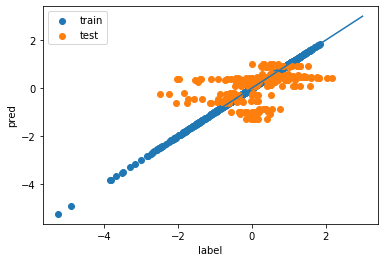

In [10]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 3, s = 0, alpha = 5, eva_on='samples')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [11]:
gpr_train_samples.train_df[gpr_train_samples.train_df['RBS'] == 'CTTAAGAAGGAGATATACAT']


,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep1,1.166174,1.166174,0.0
141,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep2,1.337018,1.337018,0.0
282,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep3,1.417248,1.417248,0.0
423,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep4,1.493800,1.493800,0.0
564,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep5,1.713526,1.713526,0.0
705,CTTAAGAAGGAGATATACAT,AGGAGA,1.425553,0.201725,bps_noncore,Rep6,1.644568,1.644568,0.0


In [12]:
wd_kernel =  WD_Shift_Kernel(l_list = [6], features = gpr_train_samples.features, s = 1)
#kernel_matrix_samples = wd_kernel.cal_kernel(np.asarray(gpr_train_samples.train_df['RBS']), np.asarray(gpr_train_samples.train_df['RBS']))
#np.linalg.eig(kernel_matrix)
kernel_matrix_samples = wd_kernel.kernel_all

TypeError: __init__() got an unexpected keyword argument 'l_list'

In [ ]:
plt.imshow(kernel_matrix_samples)
plt.colorbar()

In [ ]:
np.linalg.eigh(kernel_matrix_samples)

In [ ]:
one_vec = np.ones((kernel_matrix_samples.shape[0],1))
one_mat = np.ones(kernel_matrix_samples.shape)
row_sum = np.mean(kernel_matrix_samples,axis=0).T
K = kernel_matrix_samples - (row_sum * one_vec.T + one_vec * row_sum.T -np.mean(row_sum)*one_mat)

In [ ]:
kernel_matrix_samples

In [ ]:
kernel_matrix_samples.shape

## Train sequences

In [ ]:
gpr_train_seqs = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, normalise_kernel = True,
                   l_list = [6], s = 2, alpha = 5, use_samples_for_train=False)
gpr_train_seqs.regression()
gpr_train_seqs.scatter_plot()

## Repeated KFold

In [ ]:
import pickle

with open('kflod_results/repeated_kfold_wd_shift_logTrue_evaSeq.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [ ]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [ ]:
result_test_s0_aveSplit_aveRepeat

In [ ]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

In [ ]:
result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1).plot()

In [ ]:
result_test_s1_aveSplit_aveRepeat.where(result_test_s1_aveSplit_aveRepeat < 1).plot()

In [ ]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()

In [ ]:
# average mean square error for testing 

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).mean(axis = -1)

In [ ]:
# std of mean square error for testing

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)